In [ ]:
### Look into cleaning the data for if it dosen't fit - Look at project 3 (value_counts)

In [5]:
#To Do:

#Put genres along with lyrics and title names

# to concatenate feature datasets together 
# ex. lyric counts and song title counts
# must have same number of rows in each
# pd.concat([lyric, title], axis=1)


#Put dates into decades
#Put Duration into groups
#Put hotness/Popularity into groups by Year
#Plot different level's of hottnesst and familiarity (similar to years)

#Naive Bayess - Genre (Classification) - Especially suited for this type of data set
#Hottness (Linear REgression) - Lasso/Random Forest
#Popularity 



#Add in Song dataset (noise, hotness, vibe, etc... other features to add)



#Bokai - Graphing

In [494]:
####Imports and Setup
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import hdf5_getters as GETTERS
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import patsy
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
###########################
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
# We are using the BernoulliNB version of Naive Bayes, which assumes predictors are binary encoded.
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

msd_subset_path= '../../Capstone/MillionSongSubset'
msd_subset_data_path=os.path.join(msd_subset_path, 'data')
msd_subset_addf_path=os.path.join(msd_subset_path, 'AdditionalFiles')
assert os.path.isdir(msd_subset_path), 'wrong path'

msd_code_path='../../Capstone/MSongsDB-master/'
assert os.path.isdir(msd_code_path), 'wrong path'

sys.path.append(os.path.join(msd_code_path, 'PythonSrc'))

In [269]:
##### Definitions

def strtimedelta(starttime, stoptime):
    return str(datetime.timedelta(seconds=stoptime-starttime))

def apply_to_all_files(basedir, func=lambda x: x, ext='.h5'):
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        cnt += len(files)
        for f in files:
            func(f)
    return cnt

def func_to_get_artist_name(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    artist_name = GETTERS.get_artist_name(h5)
    all_artist_names.add(artist_name)
    h5.close()

def func_to_count_artist_id(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    artist_id = GETTERS.get_artist_id(h5)
    files_per_artist[artist_id] += 1
    h5.close()   
    

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

def update_columns(col_names, label):
    new_names = []
    new_names.append(col_names[0])
    for name in col_names[1:]:
        name = label + name
        new_names.append(name)
    return new_names

def is_ascii(column):
    column_list = []
    for col in column:
        for letter in col:
            if ord(letter) > 128:
                column_list.append(col)
                continue
    return column_list

In [8]:
# #### H5 file format Commands/Setup (Along with SQL commands)
# print 'number of song files:', apply_to_all_files(msd_subset_data_path)    

# all_artist_names = set()

# print 'found', len(all_artist_names), 'unique artist names'

# # see some of the content of 'all_artist_names'
# for k in range(5):
#     print list(all_artist_names)[k]
    
# #Same thing as above but with SQL
# conn = sqlite3.connect(os.path.join(msd_subset_addf_path, 'subset_track_metadata.db'))
# q="SELECT DISTINCT artist_name FROM songs"
# t1 = time.time()
# res = conn.execute(q)
# all_artist_names_sqlite = res.fetchall()
# t2 = time.time()
# print 'all artist names extracted (SQLite) in:', strtimedelta(t1,t2)
# conn.close()
# for k in range(20):
#     print all_artist_names_sqlite[k][0]
    
# # Using SQL lets find the artist with the most songs in the dataset using the artist_id
# conn = sqlite3.connect (os.path.join(msd_subset_addf_path, 'subset_track_metadata.db'))
# q = "SELECT DISTINCT artist_id FROM songs"
# res = conn.execute(q)
# all_artist_ids = map(lambda x: x[0], res.fetchall())
# conn.close()
# for k in range(5):
#     print all_artist_ids[k]
    
    
# # Make a dictionry of the artist_id and the count
# files_per_artist = {}
# for aid in all_artist_ids:
#     files_per_artist[aid] = 0   
# apply_to_all_files(msd_subset_data_path, func=func_to_count_artist_id)

# # Ex: Most popular artist with the most songs:
# most_pop_aid = sorted(files_per_artist, key=files_per_artist.__getitem__, reverse=True)[0]
# print most_pop_aid, 'has', files_per_artist[most_pop_aid], 'songs'

# # Combine the artist name with the artist_id using SQL
# conn = sqlite3.connect(os.path.join(msd_subset_addf_path, 'subset_track_metadata.db'))
# q = "SELECT DISTINCT artist_name FROM songs"
# q += " Where artist_id='"+most_pop_aid+"'"
# res = conn.execute(q)
# pop_artist_names = map(lambda x: x[0], res.fetchall())
# conn.close()
# print 'SQL query:',q
# print 'name of the most popular artist:', pop_artist_names

In [9]:
# ### Do the same work above with SQL to find the most pupular artist and the songs
# t1 = time.time()
# conn = sqlite3.connect(os.path.join(msd_subset_addf_path,
#                                     'subset_track_metadata.db'))
# q = "SELECT DISTINCT artist_id,artist_name,Count(track_id) FROM songs"
# q += " GROUP BY artist_id"
# res = conn.execute(q)
# pop_artists = res.fetchall()
# conn.close()
# t2 = time.time()
# print 'found most popular artist in',strtimedelta(t1,t2)
# print sorted(pop_artists,key=lambda x:x[2],reverse=True)[0]

In [10]:
conn_addf_art_similarity = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_artist_similarity.db')
conn_addf_art_term = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_artist_term.db')
conn_addf_metadata = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_track_metadata.db')
conn_lyric = sqlite3.connect('../../Capstone/mxm_dataset.db')

In [11]:
df_similarity_similarity = pd.read_sql("SELECT * FROM similarity", con=conn_addf_art_similarity)
df_term_artist_mbtag = pd.read_sql("SELECT * FROM artist_mbtag", con=conn_addf_art_term)
df_term_artist_term = pd.read_sql("SELECT * FROM artist_term", con=conn_addf_art_term)
df_metadata_songs = pd.read_sql("SELECT * FROM songs", con=conn_addf_metadata)
df_lyric_lyrics = pd.read_sql("SELECT * FROM lyrics", con=conn_lyric)
df_genre = pd.read_csv('../../Capstone/genre.csv')

In [ ]:
df_lyric_lyrics_wide = df_lyric_lyrics.pivot_table(index='track_id', 
                                                   columns='word', 
                                                   values='count',
                                                    fill_value=0).reset_index()

In [30]:
df_lyric_lyrics.head()
df_lyric_lyrics.drop('is_test', axis=1, inplace=True)

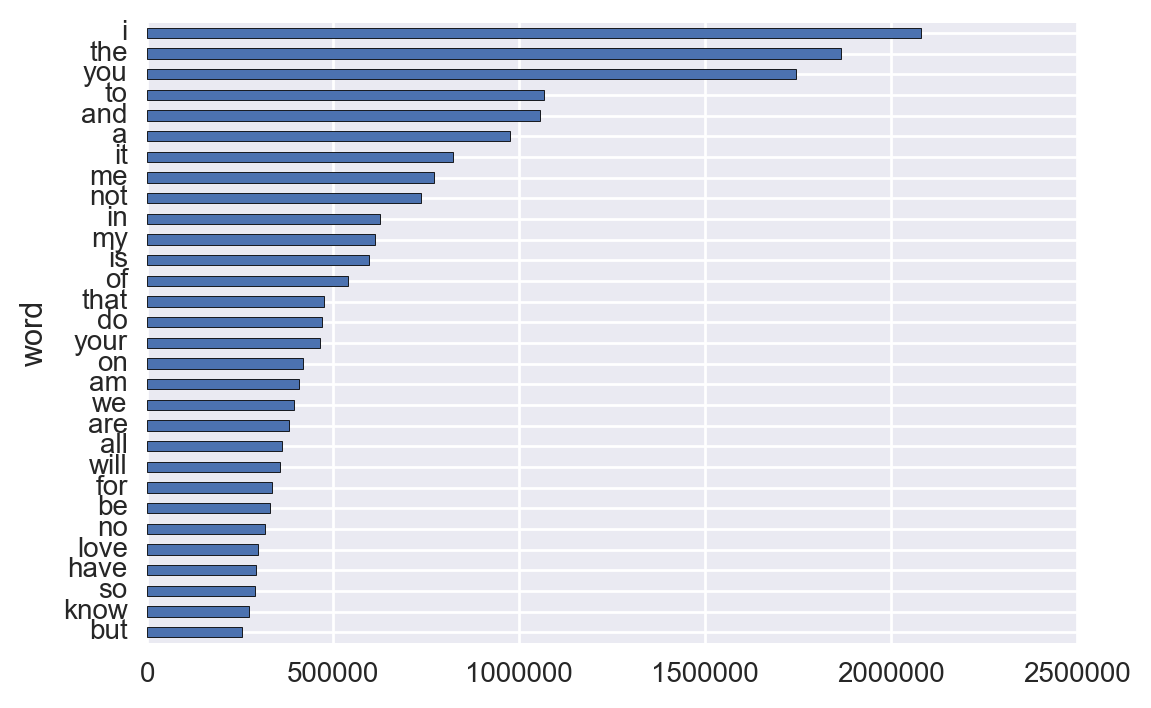

In [31]:
#Look into exploration of the lyrics dataframe
df_lyric_lyrics.groupby('word')['count'].sum().sort_values().tail(30).plot(kind="barh")

In [238]:
cv = CountVectorizer(ngram_range=(1,3), max_features=2500, binary=True, stop_words='english')
words = cv.fit_transform(df_metadata_songs['release'])

In [239]:
words.shape

(10000, 2500)

In [240]:
words = pd.DataFrame(words.todense(), columns=cv.get_feature_names())

In [258]:
words.shape

(10000, 2500)

In [359]:
totals = words.sum(axis=1).sort_values(ascending=True)
# totals

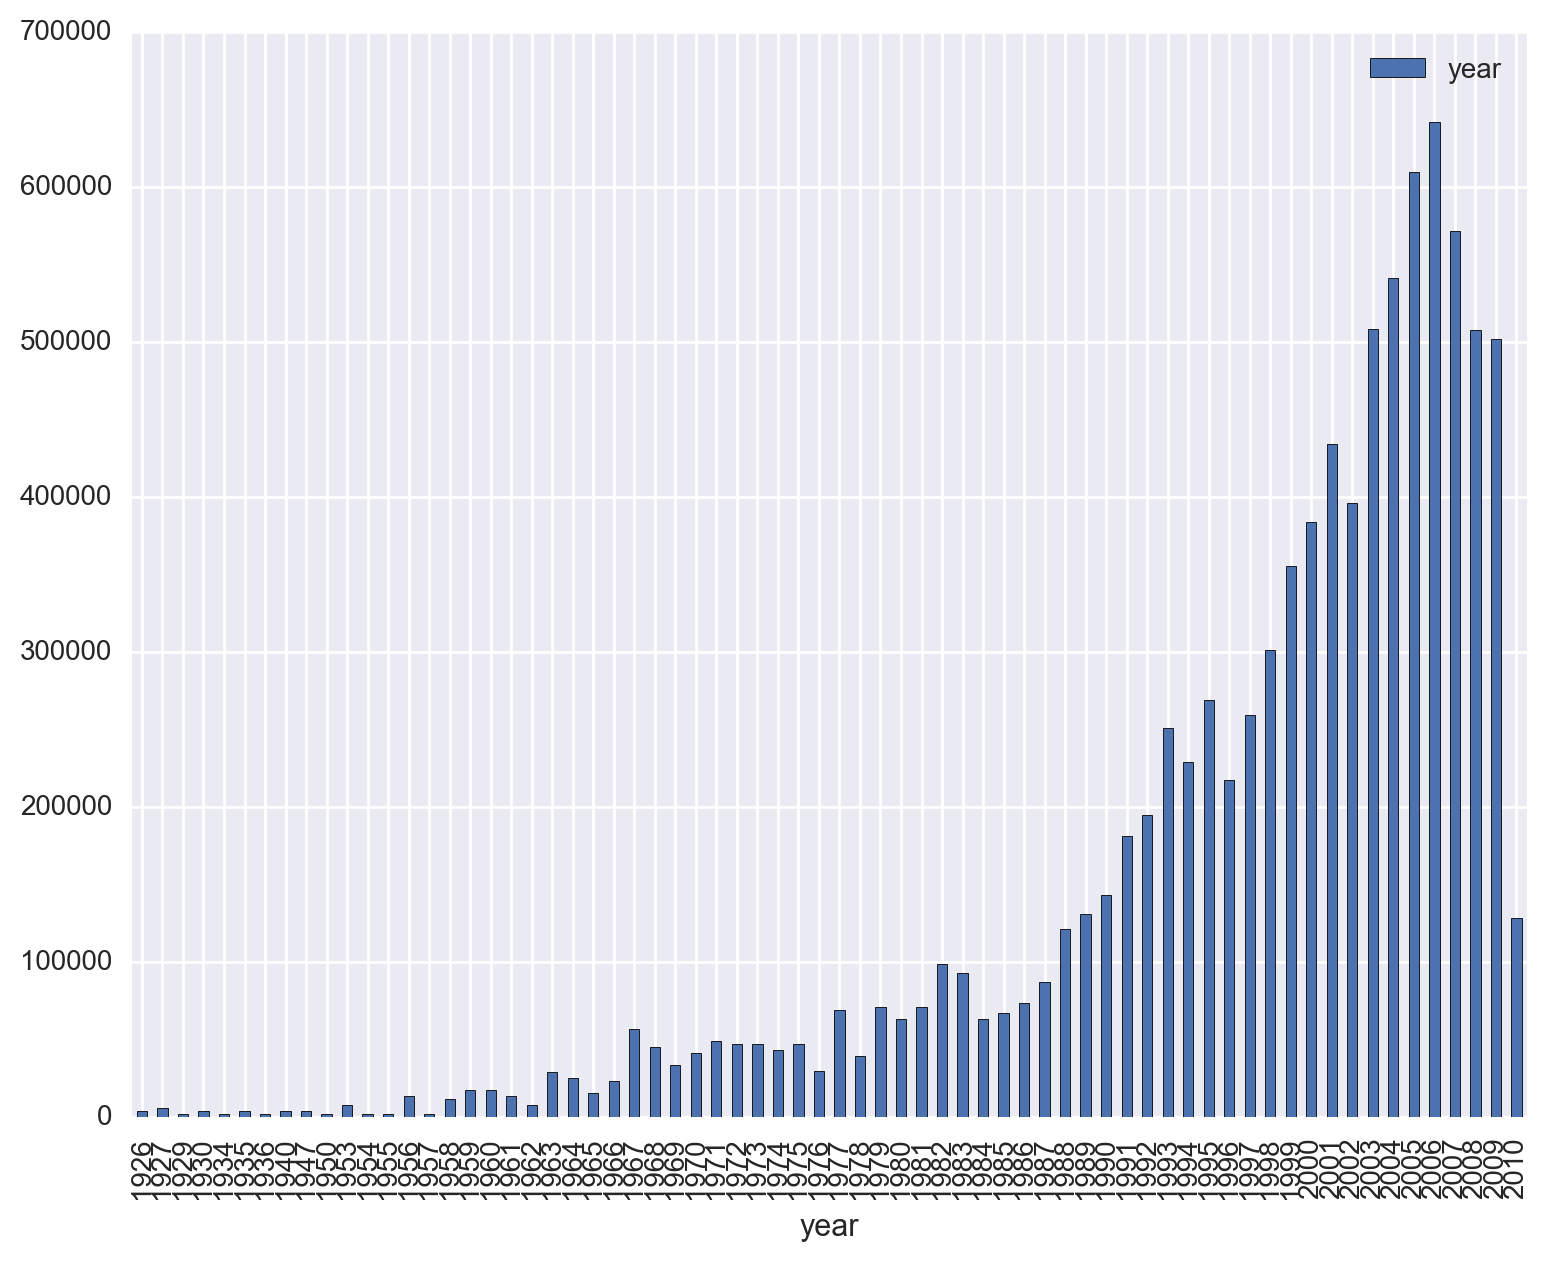

In [158]:
df_year = df_metadata_songs[(df_metadata_songs['year'] != 0)]
df_year.groupby('year').agg({'year':np.sum}).plot(kind='bar', figsize=(9,7))

In [176]:
# def decade(column):
#     for year in column:
#         print year
#         if year >= 1920 or year <= 1929:
#             year = '1920-1929'
#         else:
#             year = 'yep'

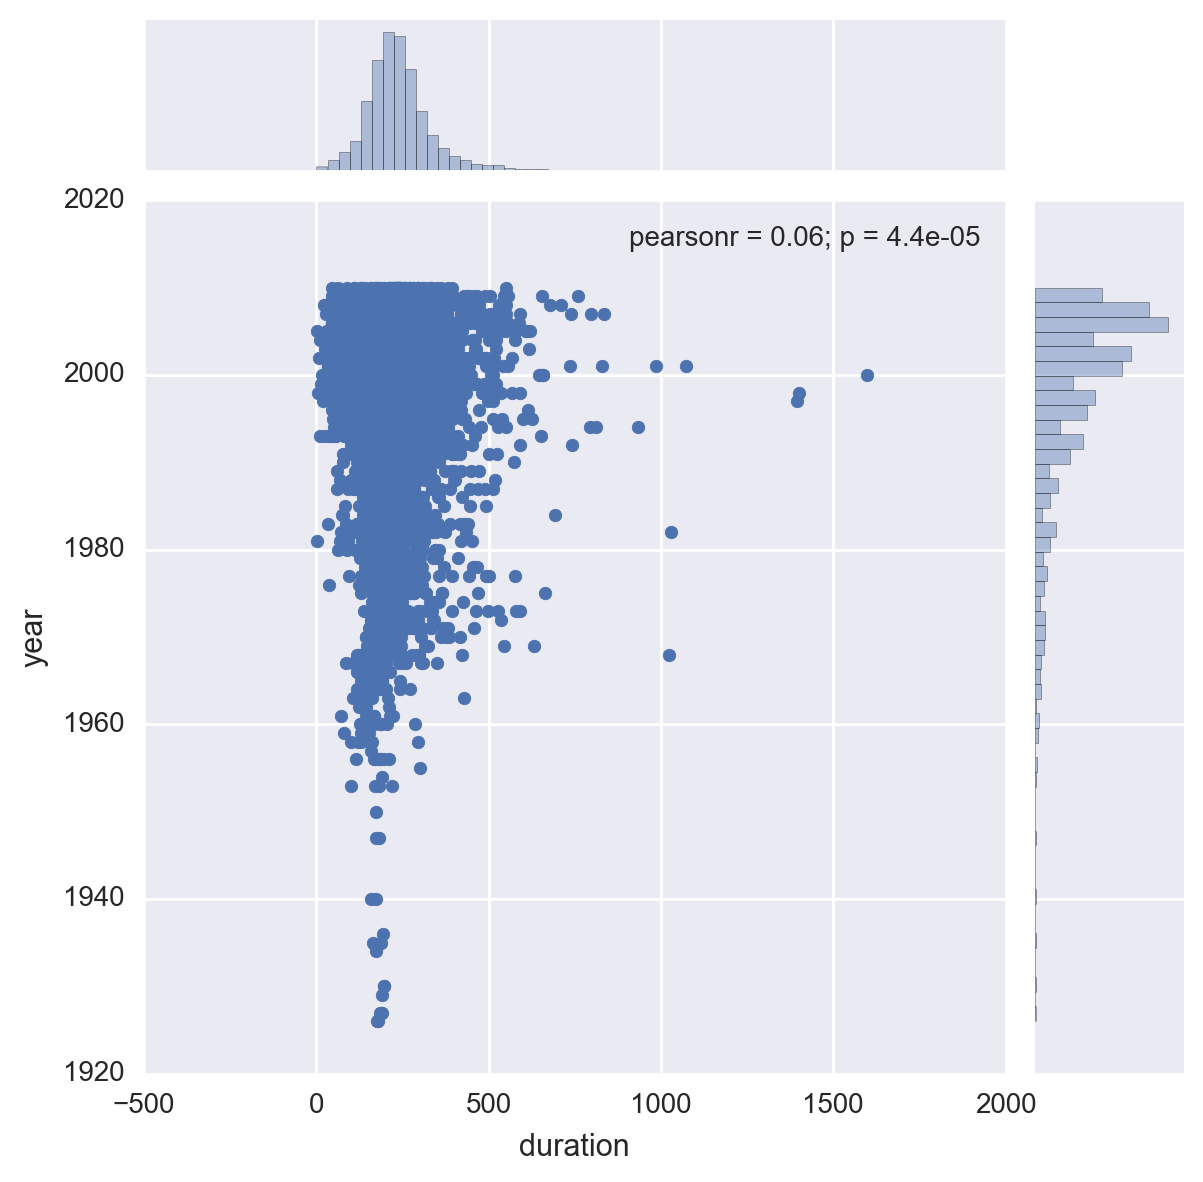

In [162]:
sns.jointplot(df_metadata_songs['duration'], df_year['year'])

In [257]:
df_metadata_songs.groupby('duration').agg({'duration':np.sum}).plot(kind='bar', figsize(9,7))

SyntaxError: non-keyword arg after keyword arg (<ipython-input-257-1ff6f56e37cf>, line 1)

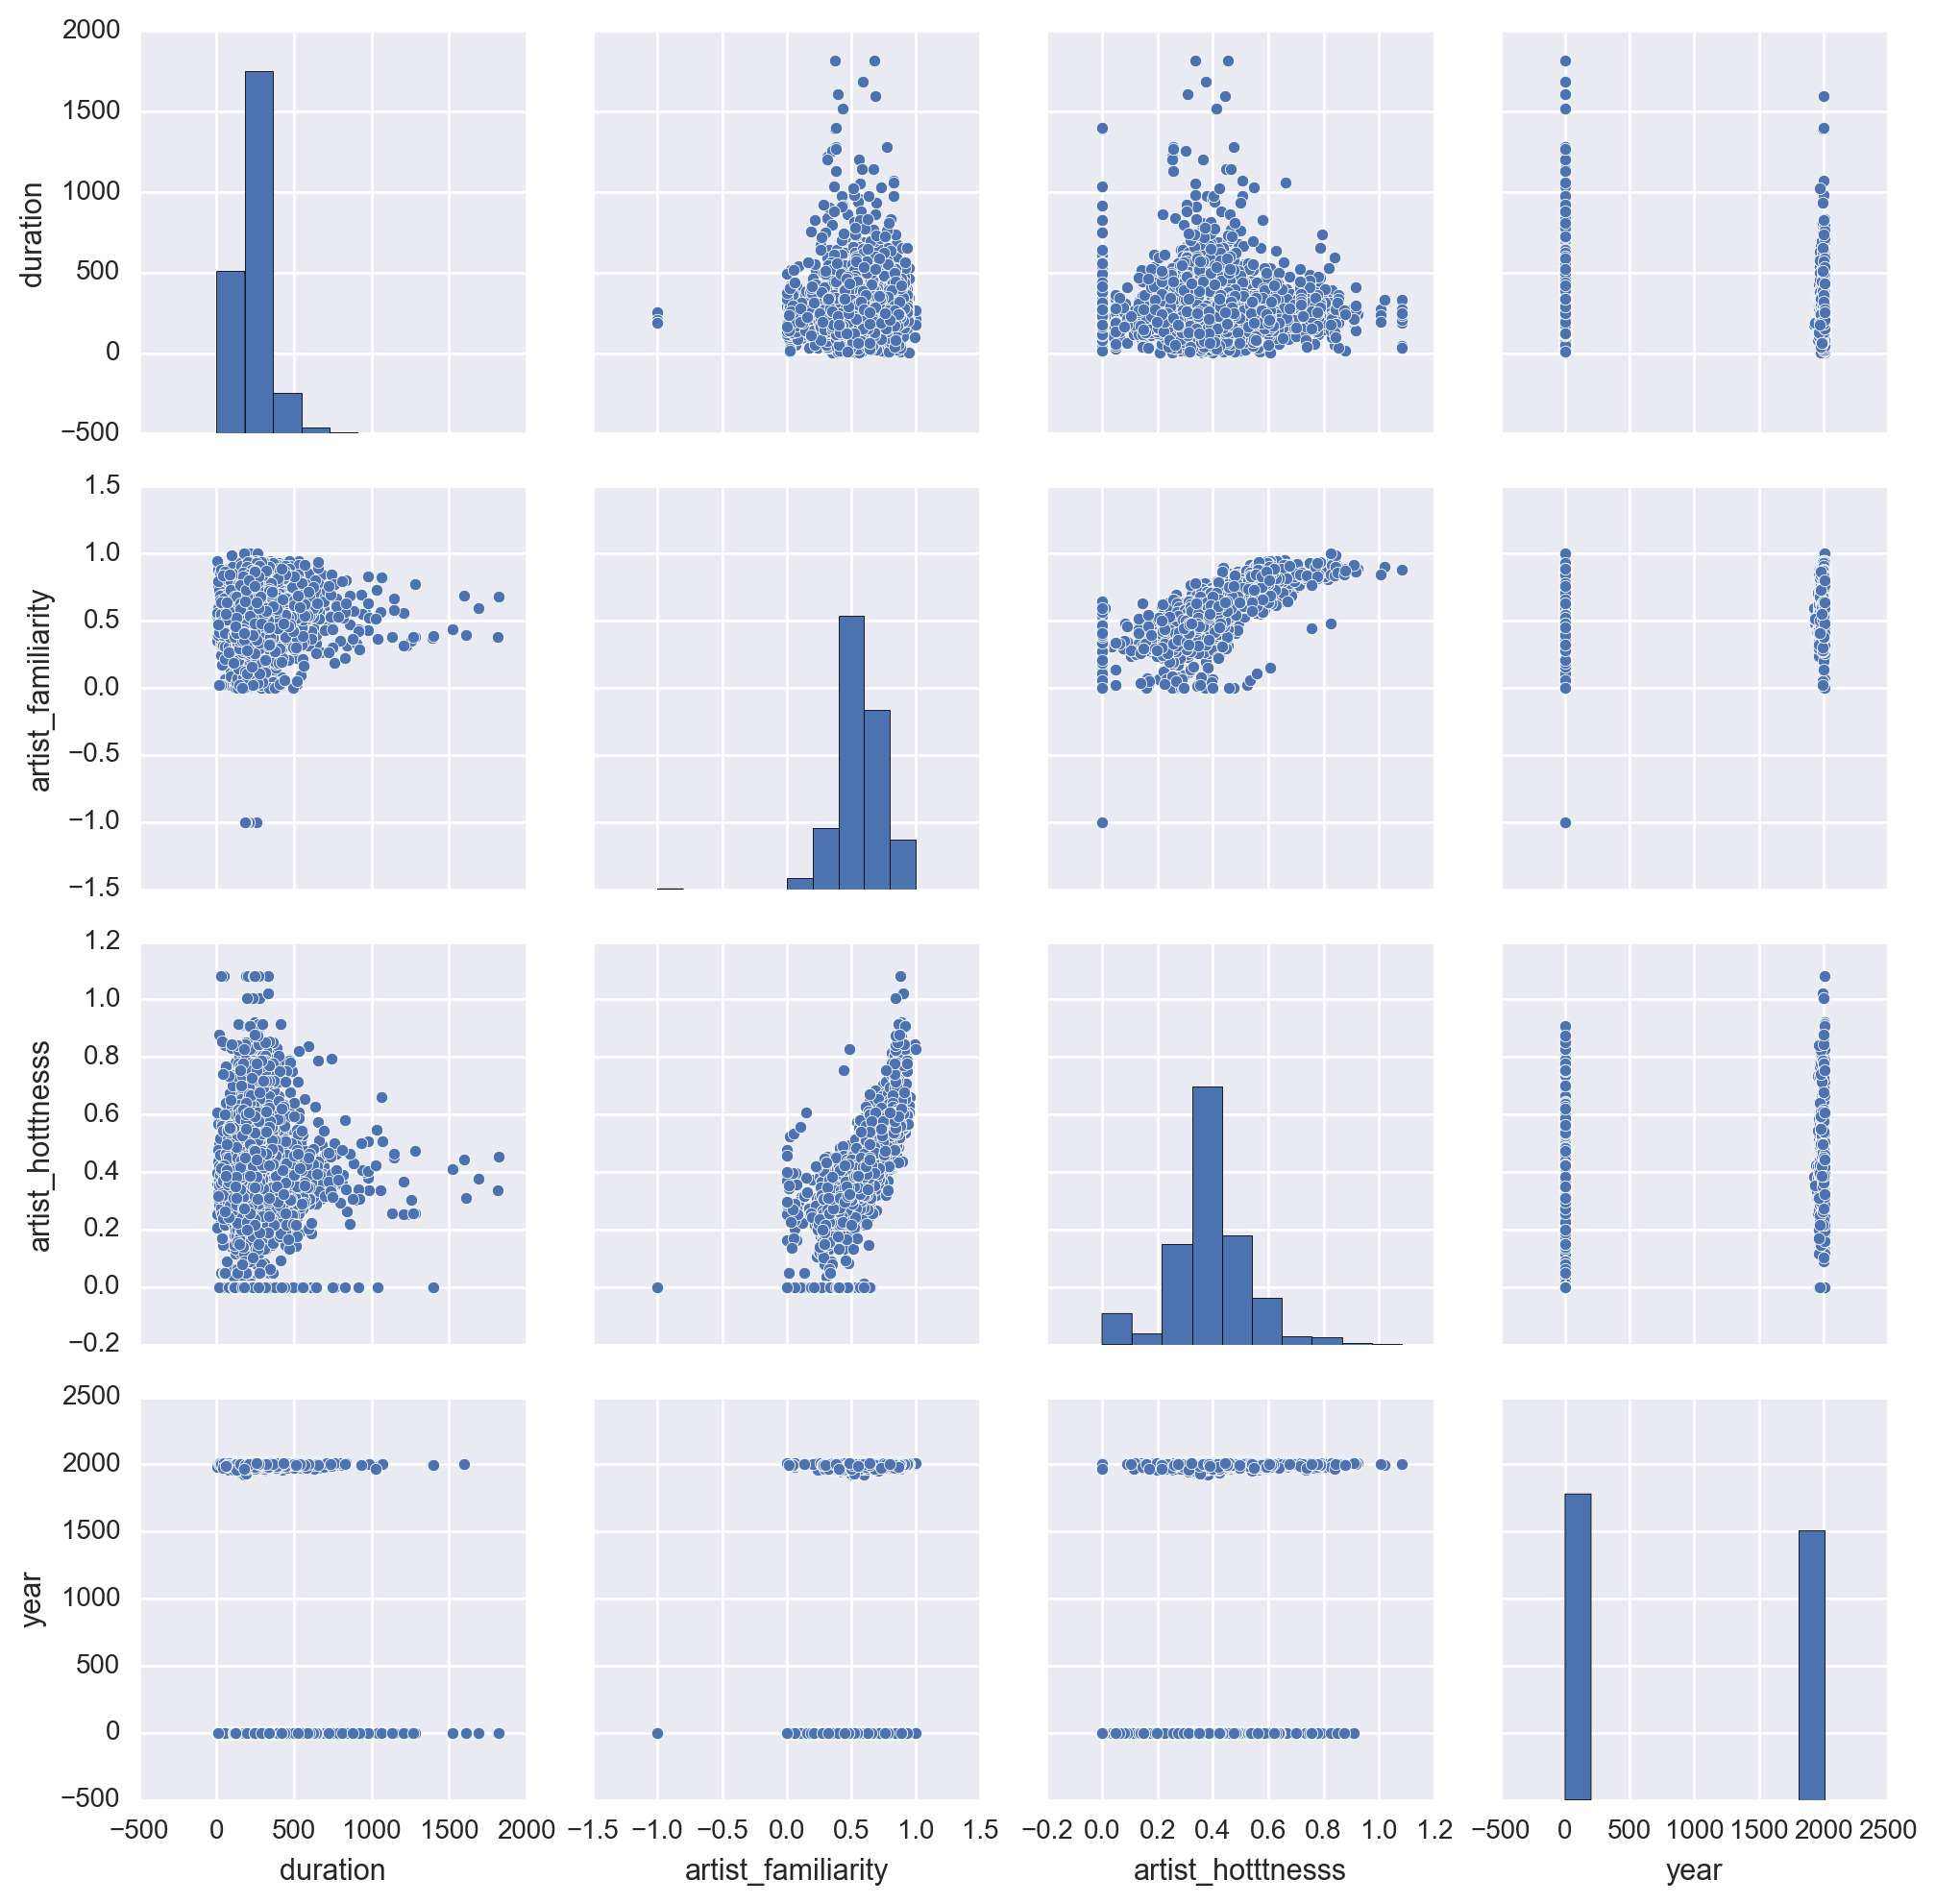

In [118]:
#### Re-do this when decades are parsed


sns.pairplot(df_metadata_songs)

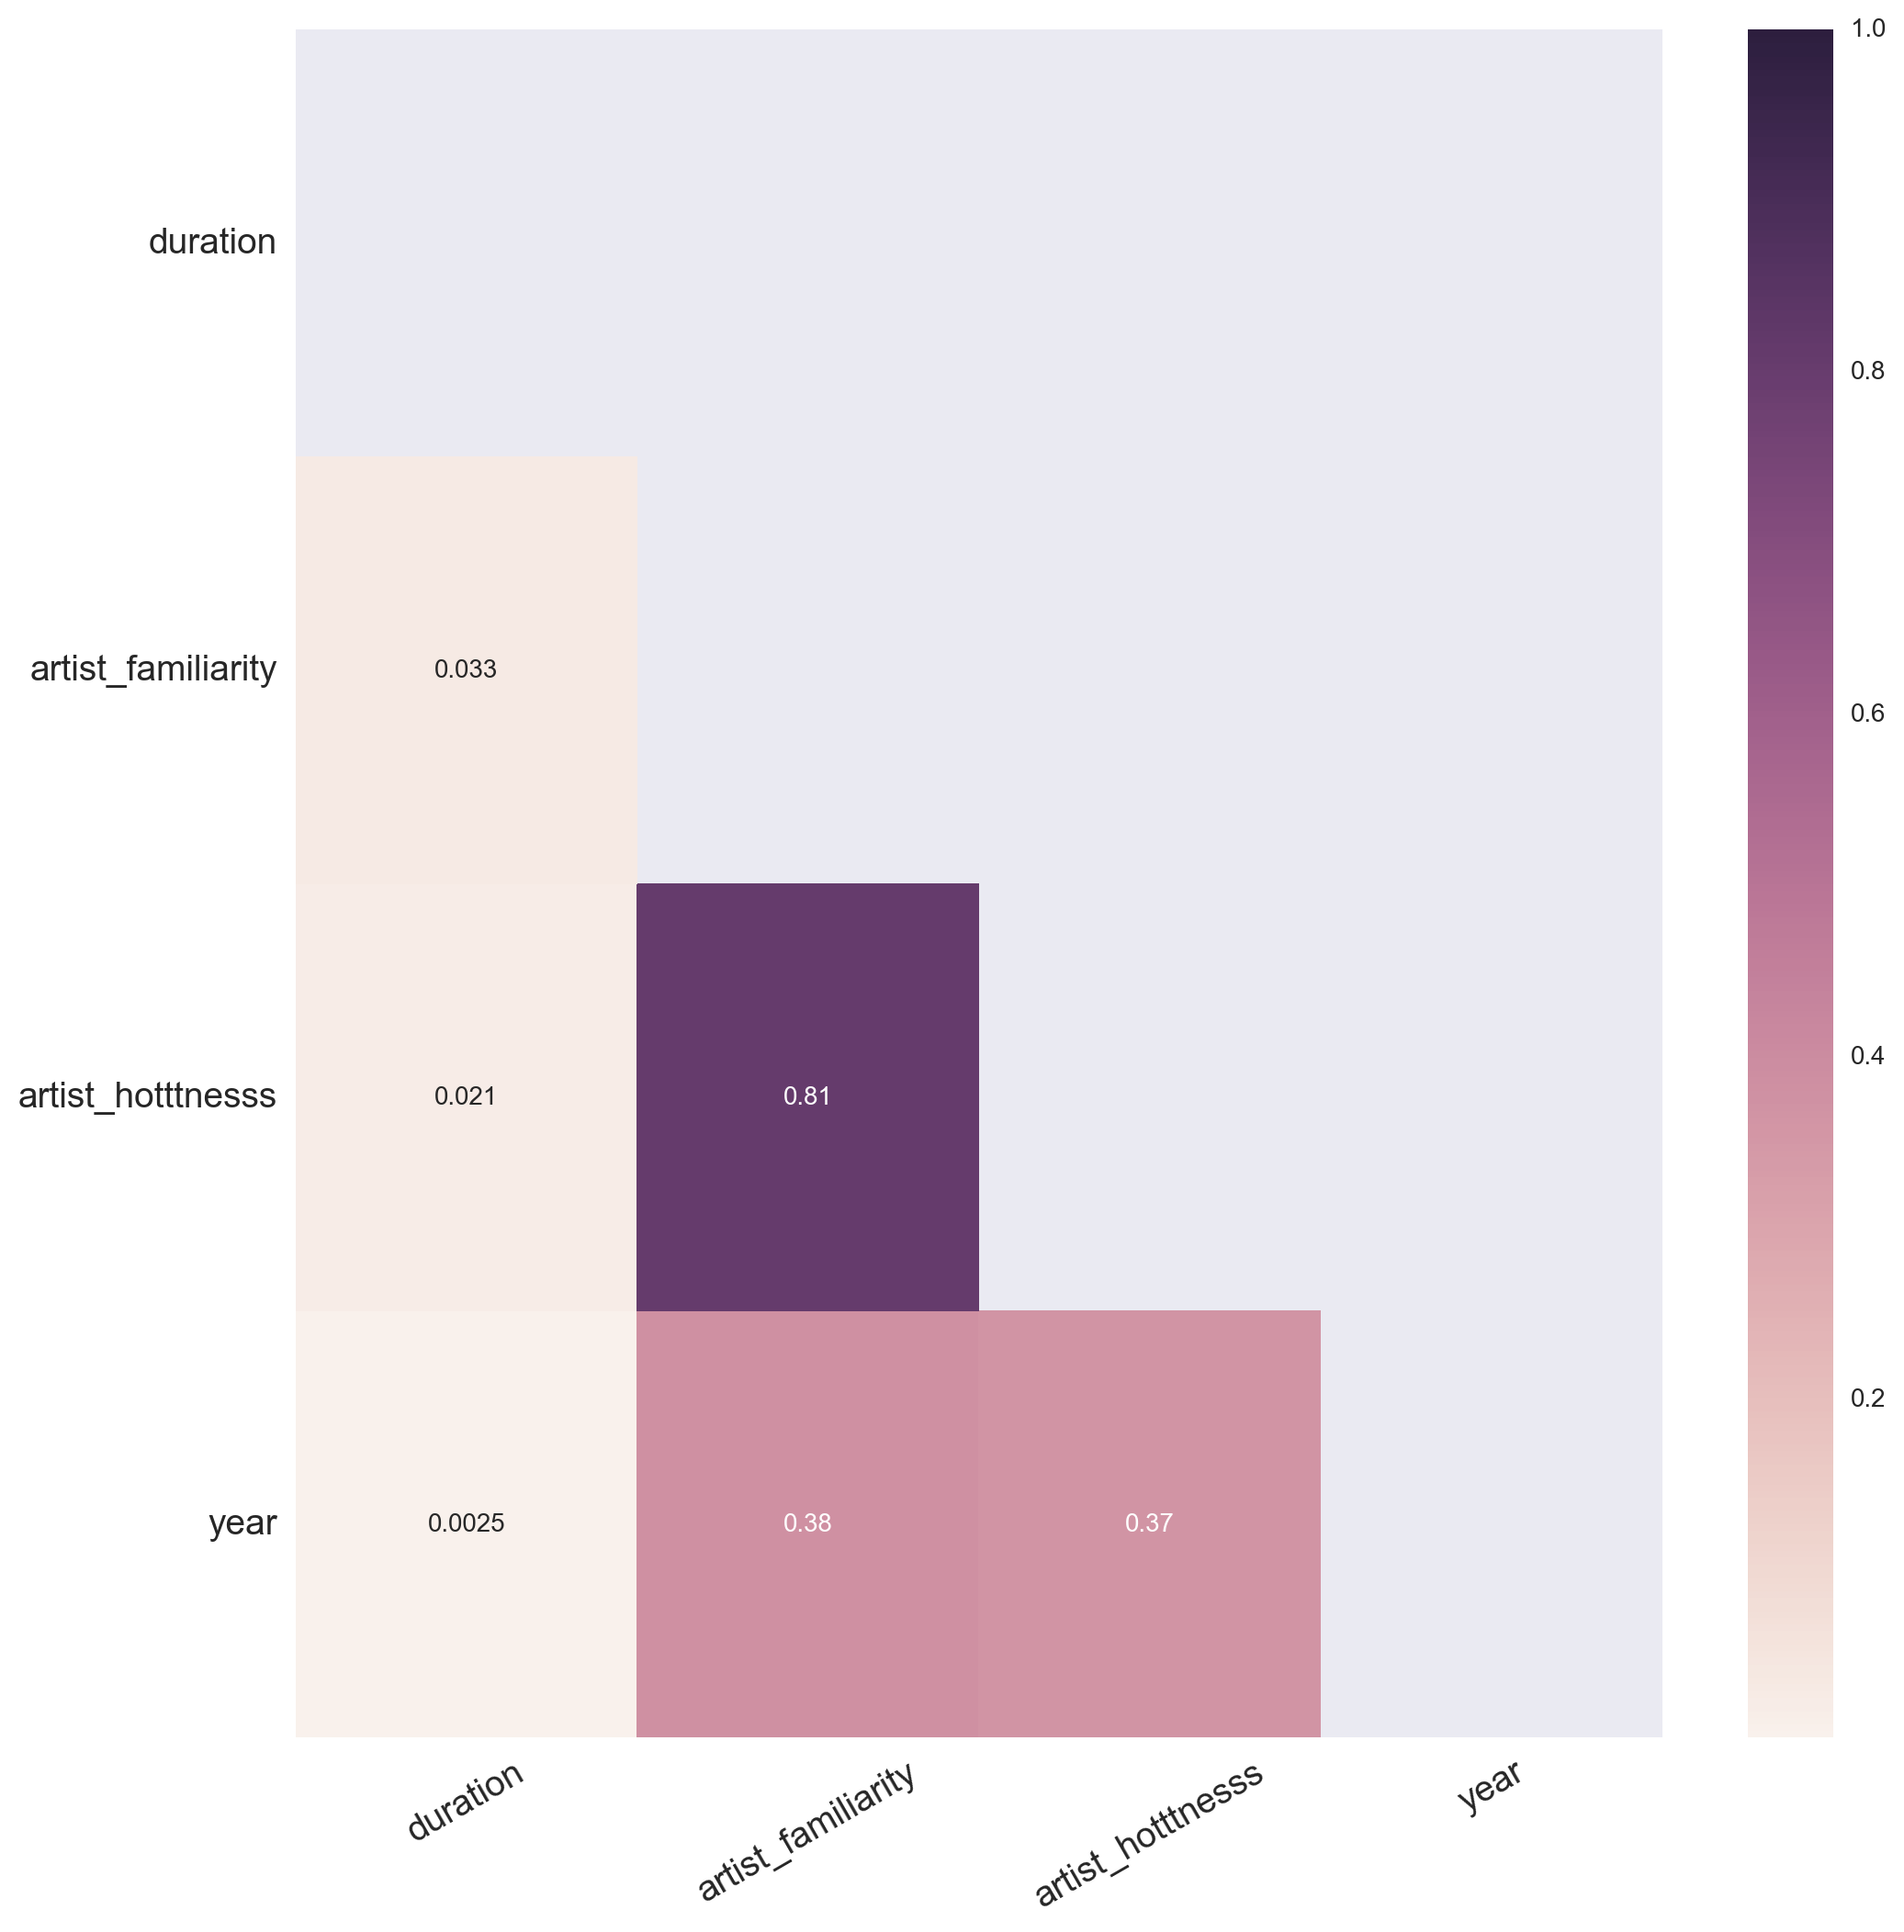

In [119]:
correlation_heat_map(df_metadata_songs)

In [ ]:
correlation_heat_map(df_)

In [278]:
df_term_artist_mbtag.head()

,artist_id,mbtag,values
0,AR00A6H1187FB5402A,detroit,1
1,AR00A6H1187FB5402A,punk,1
2,AR00A6H1187FB5402A,michigan,1
3,AR00A6H1187FB5402A,usa,1
4,AR01VU31187B997DA0,hard rock,1


In [279]:
df_term_artist_mbtag.shape

(3809, 3)

In [280]:
###Convert the tag dataframe into its wide format and display the count of genres
###from the mbtag resource (based on artist_id)
df_term_artist_mbtag['values'] = 1
df_term_artist_mbtag_wide = df_term_artist_mbtag.pivot_table(index='artist_id', 
                                          columns='mbtag', 
                                          values='values',
                                          fill_value=0).reset_index()

In [281]:
df_term_artist_mbtag_wide.head()

mbtag,artist_id,00s,1 13 165900 150 7672 22647 34612 48720 59280 74602 87545 95495 107182 131087 141522 153710,1 7 186240 183 23558 41608 89158 111733 150833 169883,10s,1960s,1970s,1980s,1990s,2000s,...,wp musicians,wu-tang,x,yé-yé,zouk,zydeco,éire,ਪੰਜਾਬੀ,ਭੰਗੜਾ,香港歌手
0,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR01VU31187B997DA0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR01W2D1187FB5912F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR022JO1187B99587B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR02IU11187FB513F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [282]:
df_term_artist_mbtag_wide.shape

(1091, 727)

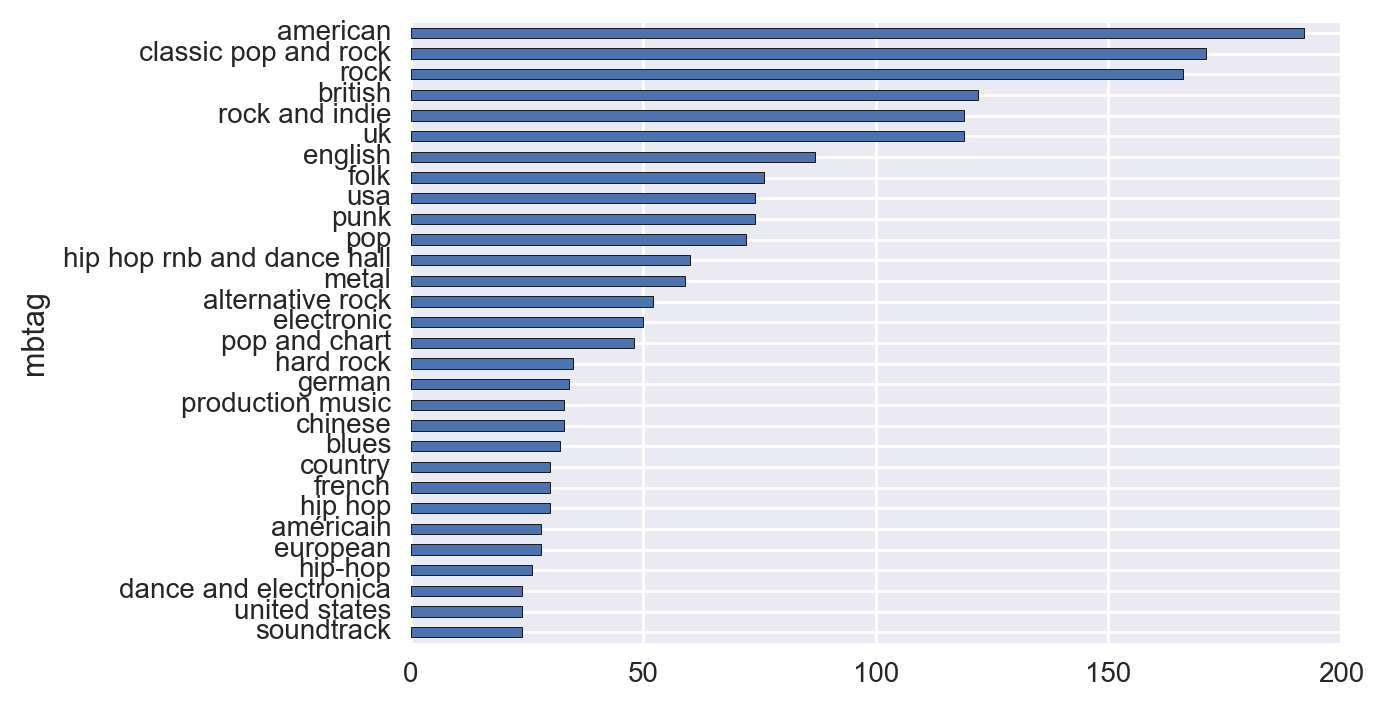

In [283]:
df_term_artist_mbtag.groupby('mbtag')['values'].sum().sort_values(ascending=True).tail(30).plot(kind="barh")

In [320]:
cols = list(df_term_artist_mbtag_wide.columns.values)
cols_use, cols_del = [], []
for x in cols:
    if df_term_artist_mbtag_wide[x].sum() > 15 or x == 'artist_id':
        cols_use.append(x)
    else:
        cols_del.append(x)

In [321]:
###Drop the unwanted columns from the table (that had less than 8)

##I chose the number "8" here because I want to remove any noise from the data set
##I need to make sure that all the information available is relevant and dosen't represent
##an artist or a song already. For example, "Weezer" is represented once already and would
##be a strong indicator of genre or artist...so want to remove the noise.
## I want indicators that are relevant across various artists and genres, that is why chossing
## above a certain number is helpful
df_term_artist_mbtag_wide = df_term_artist_mbtag_wide.drop(cols_del, axis=1)

In [322]:
df_term_artist_mbtag_wide.head()

,artist_id,mbtag_alternative rock,mbtag_american,mbtag_américain,mbtag_blues,mbtag_blues rock,mbtag_britannique,mbtag_british,mbtag_chinese,mbtag_classic pop and rock,...,mbtag_punk,mbtag_punk rock,mbtag_rnb,mbtag_rock,mbtag_rock and indie,mbtag_soul and reggae,mbtag_soundtrack,mbtag_uk,mbtag_united states,mbtag_usa
0,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,AR01VU31187B997DA0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,AR01W2D1187FB5912F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,AR022JO1187B99587B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR02IU11187FB513F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [323]:
df_term_artist_mbtag_wide.shape

(1091, 43)

In [324]:
df_term_artist_mbtag_wide.columns = update_columns(df_term_artist_mbtag_wide.columns, 'mbtag_')

In [325]:
##Get the tag data set into a format with valuable information to
##combine with other data (uniquely identify the titles so I know which tags are which)
df_term_artist_mbtag_wide.head()

,artist_id,mbtag_mbtag_alternative rock,mbtag_mbtag_american,mbtag_mbtag_américain,mbtag_mbtag_blues,mbtag_mbtag_blues rock,mbtag_mbtag_britannique,mbtag_mbtag_british,mbtag_mbtag_chinese,mbtag_mbtag_classic pop and rock,...,mbtag_mbtag_punk,mbtag_mbtag_punk rock,mbtag_mbtag_rnb,mbtag_mbtag_rock,mbtag_mbtag_rock and indie,mbtag_mbtag_soul and reggae,mbtag_mbtag_soundtrack,mbtag_mbtag_uk,mbtag_mbtag_united states,mbtag_mbtag_usa
0,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,AR01VU31187B997DA0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,AR01W2D1187FB5912F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,AR022JO1187B99587B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR02IU11187FB513F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [331]:
df_term_artist_term.head()

,artist_id,term,values
0,AR009211187B989185,lovers rock,1
1,AR009211187B989185,reggae,1
2,AR009211187B989185,roots reggae,1
3,AR009211187B989185,uk garage,1
4,AR009211187B989185,ballad,1


In [332]:
df_term_artist_term.shape

(97493, 3)

In [333]:
###Convert the term dataframe into its wide format and show the sum of the 
df_term_artist_term['values'] = 1
df_term_artist_term_wide = df_term_artist_term.pivot_table(index='artist_id',
                                                     columns='term',
                                                     values='values',
                                                     fill_value=0).reset_index()

In [334]:
df_term_artist_term_wide.head()

term,artist_id,00s,00s country,00s pop,1800s,1910s,1960s soul,1970s soul,19th century,19th century classical,...,zaire,zairean,zimbabwe,zommetal,zouk,zouklove,zxzw,zxzw 2006,zxzw 2008,zydeco
0,AR009211187B989185,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR00LNI1187FB444A5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR00MBZ1187B9B5DB1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR01IP11187B9AF5D2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [335]:
df_term_artist_term_wide.shape

(3885, 3503)

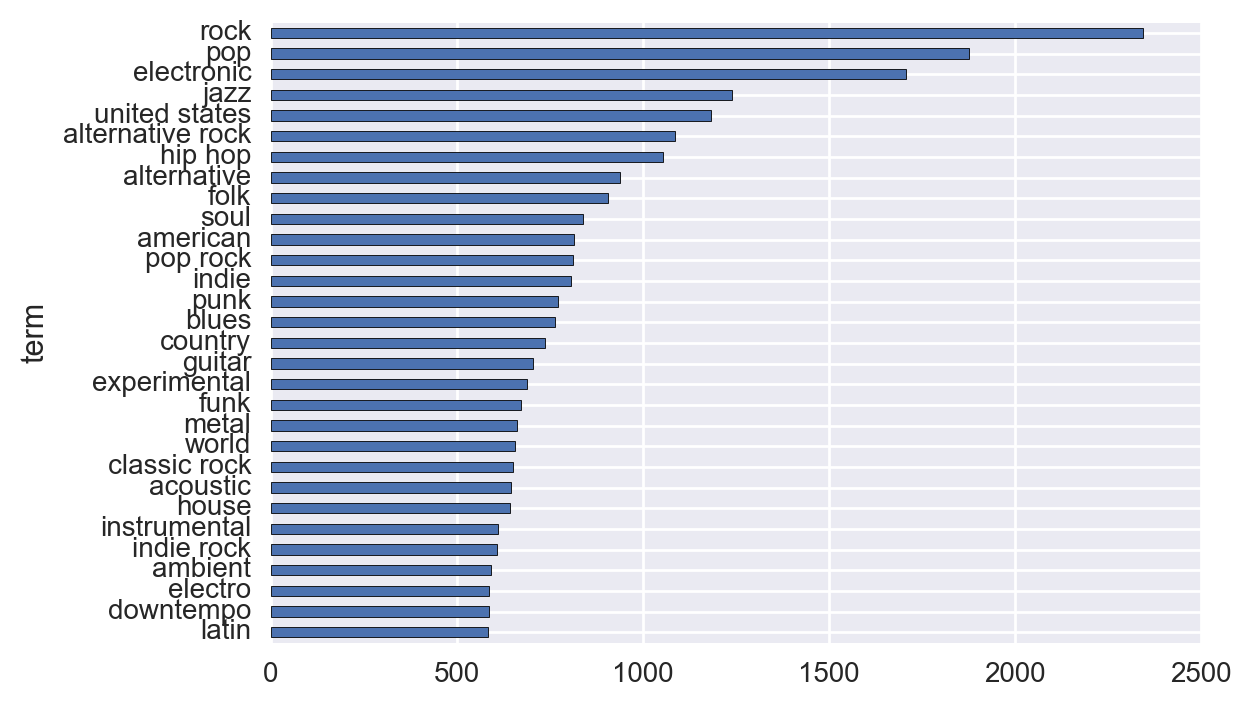

In [336]:
df_term_artist_term.groupby('term')['values'].sum().sort_values(ascending=True).tail(30).plot(kind="barh")

In [337]:
cols = list(df_term_artist_term_wide.columns.values)
cols_use, cols_del = [], []
for x in cols:
    if df_term_artist_term_wide[x].sum() > 50 or x == 'artist_id':
        cols_use.append(x)
    else:
        cols_del.append(x)

In [338]:
df_term_artist_term_wide = df_term_artist_term_wide.drop(cols_del, axis=1)

In [339]:
df_term_artist_term_wide.head()

term,artist_id,00s,50s,60s,70s,80s,90s,abstract,acid,acid jazz,...,vocal,vocal jazz,vocalist,voice,west coast rap,world,world fusion,world music,world reggae,worship music
0,AR009211187B989185,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,AR00A6H1187FB5402A,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR00LNI1187FB444A5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR00MBZ1187B9B5DB1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,AR01IP11187B9AF5D2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [340]:
df_term_artist_term_wide.shape

(3885, 361)

In [341]:
df_term_artist_term_wide.columns = update_columns(df_term_artist_term_wide.columns, 'term_')

In [342]:
df_term_artist_term_wide.head()

,artist_id,term_00s,term_50s,term_60s,term_70s,term_80s,term_90s,term_abstract,term_acid,term_acid jazz,...,term_vocal,term_vocal jazz,term_vocalist,term_voice,term_west coast rap,term_world,term_world fusion,term_world music,term_world reggae,term_worship music
0,AR009211187B989185,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,AR00A6H1187FB5402A,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR00LNI1187FB444A5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR00MBZ1187B9B5DB1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,AR01IP11187B9AF5D2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [344]:
df_genre.head()

,track_id,genre,genre_value
0,TRAAAAK128F9318786,Pop_Rock,1
1,TRAAAAW128F429D538,Rap,1
2,TRAAABD128F429CF47,Pop_Rock,1
3,TRAAAED128E0783FAB,Jazz,1
4,TRAAAEF128F4273421,Pop_Rock,1


In [345]:
df_genre.shape

(267352, 3)

In [346]:
#Correct the columns of the genre data frame
df_genre.columns = ['track_id', 'genre', 'genre_value']


In [1]:
df_genre.to_csv('df_genre_original.csv', encoding='utf-8')

NameError: name 'df_genre' is not defined

In [347]:
#Convert the genre dataframe into its wide format (based on the track_id)
df_genre['genre_value'] = df_genre['genre'].map(lambda x: 1 if type(x) == str else 0)
df_genre_wide = df_genre.pivot_table(index='track_id', 
                                     columns='genre', 
                                     values='genre_value',
                                    fill_value=0).reset_index()

In [348]:
df_genre_wide.head()

genre,track_id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,TRAAAAK128F9318786,0,0,0,0,0,0,0,0,1,0,0,0,0
1,TRAAAAW128F429D538,0,0,0,0,0,0,0,0,0,1,0,0,0
2,TRAAABD128F429CF47,0,0,0,0,0,0,0,0,1,0,0,0,0
3,TRAAAED128E0783FAB,0,0,0,0,0,1,0,0,0,0,0,0,1
4,TRAAAEF128F4273421,0,0,0,0,0,0,0,0,1,0,0,0,0


In [349]:
df_genre_wide.shape

(133676, 14)

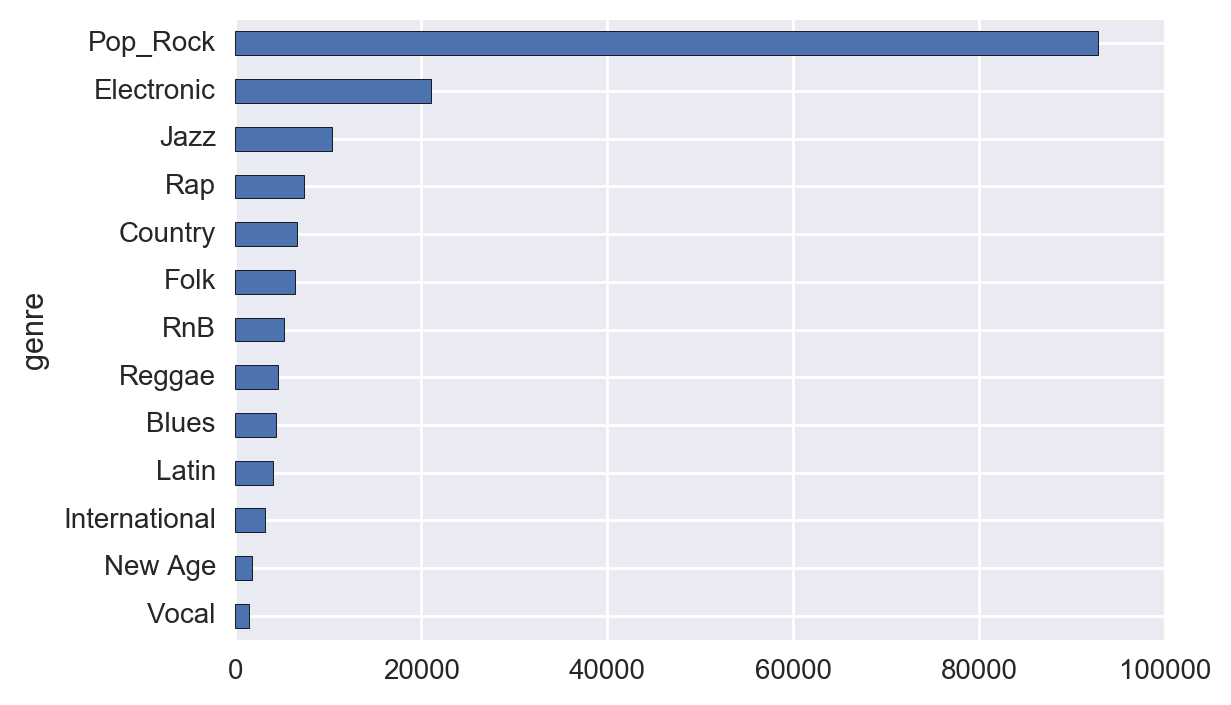

In [350]:
df_genre.groupby('genre')['genre_value'].sum().sort_values().plot(kind="barh")

In [ ]:
#Familiarity – this corresponds to how well known in artist is.  
#You can look at familiarity as the likelihood that any person selected at random will 
#have heard of the artist.  Beatles have a familiarity close to 1, while a band like 
#‘Hot Rod Shopping Cart’ has a familiarity close to zero.


#Hotttnesss – this corresponds to how much buzz the artist is getting right now. 
#This is derived from many sources, including mentions on the web, 
#mentions in music blogs, music reviews, play counts, etc.

In [ ]:
###Setting up a dataframe to do initial modeling with terms, tags, genres.
###This original dataframe is only connection on artist_id because the tag and term
###documentation have those as keys

In [389]:
print df_metadata_songs.shape
print df_genre_wide.shape
print df_term_artist_mbtag_wide.shape
print df_term_artist_term_wide.shape

(10000, 11)
(133676, 14)
(1091, 43)
(3885, 361)


In [ ]:
###Certain ways to combine the data sets based on artist and song

# df_comb = pd.merge(df_comb, df_term_artist_mbtag_wide, how='inner', on='artist_id')
# df_comb.shape

# df_comb = pd.merge(df_comb, df_genre_wide, how='inner', on='track_id')
# df_comb.shape

In [ ]:
####Initial modeling for Hotttness using a binary indicator of hot or not (using genre)

###Do I need to normalized? Do I need to standardize it?

In [474]:
df_comb_hott = pd.merge(df_metadata_songs, df_genre_wide, how='inner', on='track_id')
df_comb_hott.shape

(1390, 24)

In [475]:
df_comb_hott['is_hot'] = df_comb_hott['artist_hotttnesss'].map(lambda x: 1 if x >= .7 else 0 )

In [476]:
df_comb_hott.shape

(1390, 25)

In [477]:
remove_cols = ['track_id', 'title', 'song_id', 
               'release', 'artist_id', 'artist_mbid', 
               'artist_name', 'artist_familiarity', 'artist_hotttnesss']

In [478]:
df_comb_hott = df_comb_hott.drop(remove_cols, axis=1)

In [479]:
df_comb_hott.shape

(1390, 16)

In [480]:
##Remove any "years" where there is no data
df_comb_hott = df_comb_hott[(df_comb_hott['year'] != 0)]

In [481]:
df_comb_hott.shape

(1138, 16)

In [482]:
df_comb_hott.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

In [483]:
####Able to put column of what I want at the beginning for predicting capabilities
cols = df_comb_hott.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_comb_hott = df_comb_hott[cols]

In [484]:
df_comb_hott.head()

,is_hot,duration,year,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,0,280.21506,2001,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,89.15546,2010,0,0,1,0,0,0,0,0,1,0,0,0,0
3,0,280.24118,2009,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,149.91628,2004,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,323.18649,2007,0,0,0,0,0,0,0,0,1,0,0,0,0


In [485]:
###Use Patsy to predict a logisitc regression
not_predictors = ['is_hot']
formula = 'is_hot ~ ' + ' + '.join([x for x in df_comb_hott.columns if x not in not_predictors]) + ' - 1'

In [491]:
y, X = patsy.dmatrices(formula, data=df_comb_hott, return_type='dataframe')
y = y.values.ravel()

In [492]:
y.shape, X.shape

((1138,), (1138, 15))

In [497]:
lr = LogisticRegression()
ss = StandardScaler()

In [498]:
Xn = ss.fit_transform(X)

In [505]:
lr.fit(Xn,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [506]:
lr.score(Xn,y)

0.93321616871704749

In [509]:
coefs = pd.DataFrame({'coef':lr.coef_[0], 'abs_coef':np.abs(lr.coef_[0]),
                      'variable':X.columns})
coefs.sort_values('abs_coef', ascending=True, inplace=True)
coefs.head(20)

,abs_coef,coef,variable
3,0.031329,0.031329,Country
14,0.063329,0.063329,Vocal
10,0.094815,0.094815,Pop_Rock
11,0.095243,0.095243,Rap
0,0.111986,0.111986,duration
8,0.187000,0.187000,Latin
1,0.275034,0.275034,year
9,0.292187,-0.292187,New_Age
6,0.305928,-0.305928,International
2,0.353528,-0.353528,Blues


In [ ]:
##Look at the same model but with the "artist mbtag"newcols = [''.join([ch for ch in x if ch in 'abcdefghijklmnopqrstuvwxyz_']).decode('ascii','ignore')
for x in df_comb_mbtag_hott.columns]
df_comb_mbtag_hott.columns = newcols

In [624]:
df_comb_mbtag_hott = pd.merge(df_metadata_songs, df_term_artist_mbtag_wide, how='inner', on='artist_id')
df_comb_mbtag_hott.shape

(3710, 53)

In [626]:
df_comb_mbtag_hott['is_hot'] = df_comb_mbtag_hott['artist_hotttnesss'].map(lambda x: 1 if x >= .7 else 0 )

In [627]:
df_comb_mbtag_hott.shape

(3710, 54)

In [628]:
remove_cols = ['track_id', 'title', 'song_id', 
               'release', 'artist_id', 'artist_mbid', 
               'artist_name', 'artist_familiarity', 'artist_hotttnesss'] 

In [629]:
df_comb_mbtag_hott = df_comb_mbtag_hott.drop(remove_cols, axis=1)

In [630]:
df_comb_mbtag_hott.shape

(3710, 45)

In [631]:
##Remove any "years" where there is no data
df_comb_mbtag_hott = df_comb_mbtag_hott[(df_comb_mbtag_hott['year'] != 0)]

In [632]:
df_comb_mbtag_hott.shape

(2562, 45)

In [633]:
##Cleaning columns to make sure they all follow the same format
df_comb_mbtag_hott.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
##Removing any letters with columns
newcols = [''.join([ch for ch in x if ch in 'abcdefghijklmnopqrstuvwxyz_']).decode('ascii','ignore')
for x in df_comb_mbtag_hott.columns]
df_comb_mbtag_hott.columns = newcols

In [634]:
####Able to put column of what I want at the beginning for predicting capabilities
cols = df_comb_mbtag_hott.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_comb_mbtag_hott = df_comb_mbtag_hott[cols]

In [635]:
df_comb_mbtag_hott.head()

,is_hot,duration,year,mbtag_mbtag_alternative_rock,mbtag_mbtag_american,mbtag_mbtag_amricain,mbtag_mbtag_blues,mbtag_mbtag_blues_rock,mbtag_mbtag_britannique,mbtag_mbtag_british,...,mbtag_mbtag_punk,mbtag_mbtag_punk_rock,mbtag_mbtag_rnb,mbtag_mbtag_rock,mbtag_mbtag_rock_and_indie,mbtag_mbtag_soul_and_reggae,mbtag_mbtag_soundtrack,mbtag_mbtag_uk,mbtag_mbtag_united_states,mbtag_mbtag_usa
0,0,280.21506,2001,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,262.89587,2004,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,654.28853,2009,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,233.58649,2001,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,197.19791,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [636]:
###Use Patsy to predict a logisitc regression
not_predictors = ['is_hot']
formula = 'is_hot ~ ' + ' + '.join([x for x in df_comb_mbtag_hott.columns if x not in not_predictors]) + ' - 1'

In [637]:
y, X = patsy.dmatrices(formula, data=df_comb_mbtag_hott, return_type='dataframe')
y = y.values.ravel()

In [638]:
y.shape, X.shape

((2562,), (2562, 44))

In [639]:
lr = LogisticRegression()
ss = StandardScaler()

In [640]:
Xn = ss.fit_transform(X)

In [641]:
lr.fit(Xn,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [642]:
lr.score(Xn,y)

0.95979703356752533

In [648]:
coefs = pd.DataFrame({'coef':lr.coef_[0], 'abs_coef':np.abs(lr.coef_[0]),
                      'variable':X.columns})
coefs.sort_values('coef', ascending=True, inplace=True)
coefs.head(20)

,abs_coef,coef,variable
8,0.934955,-0.934955,mbtag_mbtag_british
40,0.813148,-0.813148,mbtag_mbtag_soundtrack
6,0.796556,-0.796556,mbtag_mbtag_blues_rock
34,0.685737,-0.685737,mbtag_mbtag_punk
22,0.344668,-0.344668,mbtag_mbtag_german
39,0.323092,-0.323092,mbtag_mbtag_soul_and_reggae
15,0.308900,-0.308900,mbtag_mbtag_electronic
16,0.302384,-0.302384,mbtag_mbtag_england
43,0.282395,-0.282395,mbtag_mbtag_usa
33,0.221789,-0.221789,mbtag_mbtag_production_music


In [ ]:
##Look at the same model but with the "artist term"

In [663]:
df_comb_term_hott = pd.merge(df_metadata_songs, df_term_artist_term_wide, how='inner', on='artist_id')
df_comb_term_hott.shape

(9995, 371)

In [664]:
df_comb_term_hott['is_hot'] = df_comb_term_hott['artist_hotttnesss'].map(lambda x: 1 if x >= .7 else 0 )

In [665]:
df_comb_term_hott.shape

(9995, 372)

In [666]:
remove_cols = ['track_id', 'title', 'song_id', 
               'release', 'artist_id', 'artist_mbid', 
               'artist_name', 'artist_familiarity', 'artist_hotttnesss'] 

In [667]:
df_comb_term_hott = df_comb_term_hott.drop(remove_cols, axis=1)

In [668]:
df_comb_term_hott.shape

(9995, 363)

In [669]:
##Remove any "years" where there is no data
df_comb_term_hott = df_comb_term_hott[(df_comb_term_hott['year'] != 0)]

In [670]:
df_comb_term_hott.shape

(4680, 363)

In [671]:
##Cleaning columns to make sure they all follow the same format
df_comb_term_hott.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)
##Removing any letters with columns
newcols = [''.join([ch for ch in x if ch in 'abcdefghijklmnopqrstuvwxyz_0987654321']).decode('ascii','ignore')
for x in df_comb_term_hott.columns]
df_comb_term_hott.columns = newcols

In [672]:
####Able to put column of what I want at the beginning for predicting capabilities
cols = df_comb_term_hott.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_comb_term_hott = df_comb_term_hott[cols]

In [673]:
df_comb_term_hott.head()

,is_hot,duration,year,term_00s,term_50s,term_60s,term_70s,term_80s,term_90s,term_abstract,...,term_vocal,term_vocal_jazz,term_vocalist,term_voice,term_west_coast_rap,term_world,term_world_fusion,term_world_music,term_world_reggae,term_worship_music
0,0,280.21506,2001,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,262.89587,2004,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,654.28853,2009,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,233.58649,2001,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,191.68608,1984,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0


In [679]:
###Use Patsy to predict a logisitc regression
not_predictors = ['is_hot']
formula = 'is_hot ~ ' + ' + '.join([x for x in df_comb_term_hott.columns if x not in not_predictors]) + ' - 1'

In [680]:
y, X = patsy.dmatrices(formula, data=df_comb_term_hott, return_type='dataframe')
y = y.values.ravel()

In [681]:
y.shape, X.shape

((4680,), (4680, 362))

In [682]:
lr = LogisticRegression()
ss = StandardScaler()

In [683]:
Xn = ss.fit_transform(X)

In [685]:
lr.fit(Xn,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [686]:
lr.score(Xn,y)

0.99957264957264957

In [688]:
coefs = pd.DataFrame({'coef':lr.coef_[0], 'abs_coef':np.abs(lr.coef_[0]),
                      'variable':X.columns})
coefs.sort_values('coef', ascending=False, inplace=True)
coefs.head(20)

,abs_coef,coef,variable
21,1.260479,1.260479,term_alternative_rock
11,0.791066,0.791066,term_acoustic
63,0.743517,0.743517,term_christmas_music
182,0.737002,0.737002,term_hip_hop
64,0.710140,0.710140,term_classic
260,0.685791,0.685791,term_pop_rock
88,0.656365,0.656365,term_dance_pop
214,0.624395,0.624395,term_los_angeles
337,0.622650,0.622650,term_thrash_metal
237,0.621611,0.621611,term_neo_soul
